# Benchmark Model

In this notebook, a basic benchmark model is set up for the exercise.
Two basic models are chosen and a testing framework is built to analyse the results. 

The opportunity is taken to describe the full modelling problem specific to the bag of words data preparation. We describe the key issues:

* 1. Data preparation - The BOW approach is used here for the smiles (together with molecular weight), however we must make sure to fit the BOW approach on the training data and transform the hold out set accordingly.

* 2. Modelling - The modelling problem itself is applied to the basic 'out of the box' algorithms
    * 2.1\. Random Forest
    * 2.2\. XGBoost
    
* 3. Testing - The application of the testing framework developed (a discussion of metric choices is developed here)

A key issue will also be how to exclude the null values from the modelling.
       
    

In [5]:
# Basic imports
import pandas as pd
import numpy as np
import pickle

# Sklearn data preprocessing imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# drugdiscovery code imports
import drugdiscovery as dd
from drugdiscovery import preprocessing as pp

import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier


## Data Preparation

In [6]:
source = pd.read_csv('data/data_dups_removed.csv',index_col = 0)
data = source.copy()

Let's separate the target data from the input data:

In [7]:
data.columns

Index(['Formula', 'FW', 'DSSTox_CID', 'SR-HSE', 'ID', 'SMILES', 'Molecule',
       'NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD'],
      dtype='object')

Let's separate the target data from the input feature data

In [8]:
features = ['FW','SMILES']
targets = ['SR-HSE','NR-AR', 'SR-ARE', 'NR-Aromatase', 'NR-ER-LBD', 'NR-AhR', 'SR-MMP',\
       'NR-ER', 'NR-PPAR-gamma', 'SR-p53', 'SR-ATAD5', 'NR-AR-LBD']

In [9]:
raw_X, raw_y = data[features], data[targets]

In [10]:
raw_y.head()

,SR-HSE,NR-AR,SR-ARE,NR-Aromatase,NR-ER-LBD,NR-AhR,SR-MMP,NR-ER,NR-PPAR-gamma,SR-p53,SR-ATAD5,NR-AR-LBD
0,0.0,0.0,NaN,1.0,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN
1,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN
2,0.0,0.0,NaN,0.0,0.0,0.0,NaN,NaN,0.0,1.0,0.0,0.0
3,1.0,0.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,NaN,0.0,NaN
4,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean the retrieved dataset

In [11]:
features_types = {'FW':float, 'SMILES':object}
target_types = {n:float for n in targets}

raw_X = raw_X.astype(features_types)
raw_y = raw_y.astype(target_types)

### Dealing with the nulls

As we can see from the target training dataset, there are still some nulls in the data. It does not make sense to impute the target - we also do not want remove such data points entirely (mostly because there are too many). The apporach adopted - will be to introduce a masking over the nulls, so that only those targets which are non-null are counted in the metric outputs.

In [12]:
null_mask = np.array(np.logical_not(raw_y.isnull().values),int)

So we can see that we get 1's in the null_mask for outputs we want contributions for, but 0 for those that we do not want. We then fill the null values with zeros for all of the output data. This is a choice we are making for the benchmark models, that we will rectify for in later iterations of the modelling preparation.

In [13]:
raw_y = raw_y.fillna(0.0)

For the sake of convenience, we add the mask to the target data

In [14]:
mask_df = pd.DataFrame(null_mask, columns = [r+'_mask' for r in raw_y.columns], index = raw_y.index)
raw_y = pd.concat([raw_y,mask_df],1)

### Split the data

In [15]:
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(raw_X, raw_y, test_size = test_size, random_state=42)

y_train, mask_train = y_train[targets], y_train[mask_df.columns]
y_test, mask_test = y_test[targets], y_test[mask_df.columns]

### Transform the data set

We will make use of the BOW approach, together with the molecular weight.


In [16]:
smiles = X_train['SMILES'].values
bow = pp.BagOfWords(smiles)
bow_train = bow.fit()
bow_test = bow.transform(X_test['SMILES'].values)

In [17]:
bow_train = np.insert(bow_train, 0, X_train['FW'], 1)
bow_test = np.insert(bow_test, 0, X_test['FW'], 1)

In [18]:
#stamdardise the data
scaler = StandardScaler()
bow_train = scaler.fit_transform(bow_train)
bow_test = scaler.transform(bow_test)

In [19]:
X_train, X_test = bow_train, bow_test

So the data now looks like X_train, X_test ,y_train, y_test but BOW and scale fittings have been applied to X_train and the fitted transformations applied for the test data.

## Modelling

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

In [21]:
# We take the generic model
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

pickle.dump(rf_model, open('models/rf_bechmark_model.pkl', 'wb'))

### XGBoostClassifier

In [22]:
xgb_model = xgb.XGBClassifier()
xgb_model = MultiOutputClassifier(xgb_model)
xgb_model.fit(X_train, y_train)

pickle.dump(xgb_model, open('models/xgb_bechmark_model.pkl', 'wb'))

## Testing

A testing 'framework' has been developed in `drugdiscovery/testing/py` and involves creating a dataframe with the following metrics:

Precision, Recall,	F1,	AUPRC,	Accuracy,	Balanced Accuracy,	ROC_AUC

We are mostly interested in the interplay between Precision, Recall whilst F1 shows us a more general representation of the two. AUPRC is the area under the precision/recall curve, which is important given the target imbalance. The remaining metrics are there for completeness.

The framework also includes a plotter for all for all of the testing targets, and will be displayed below.

In [23]:
from drugdiscovery import testing

In [24]:
def get_pred_and_scores(model, X):
    y_pred = model.predict(X)
    y_score = np.array([model.predict_proba(X)[i][:,1] for i in range(0,12)]).T
    return y_pred, y_score

### Random Forest

#### Training

In [25]:
y_pred, y_score = get_pred_and_scores(rf_model, X_train)
y_obs = y_train.values

test_panel = testing.panel_of_test(targets, X_train, y_train.values, sample_weights = mask_train.values)
test_panel.compute_basic_metrics(y_pred, y_score)

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,1,0.938697,0.968379,0.997959,0.996384,0.969349,0.969349
NR-AR,1,0.957547,0.978313,0.99888,0.998203,0.978774,0.978774
SR-ARE,0.988871,0.964341,0.976452,0.997576,0.992494,0.981126,0.981126
NR-Aromatase,1,0.97549,0.987593,0.999556,0.998751,0.987745,0.987745
NR-ER-LBD,0.995763,0.955285,0.975104,0.998705,0.997486,0.977532,0.977532
NR-AhR,0.99604,0.961759,0.978599,0.999228,0.995101,0.980628,0.980628
SR-MMP,0.993661,0.973602,0.983529,0.999398,0.994737,0.986204,0.986204
NR-ER,0.987928,0.910946,0.947876,0.993268,0.987252,0.954662,0.954662
NR-PPAR-gamma,1,0.953488,0.97619,0.998943,0.998646,0.976744,0.976744
SR-p53,1,0.972414,0.986014,0.999614,0.998281,0.986207,0.986207


#### Testing

In [26]:
y_pred, y_score = get_pred_and_scores(rf_model, X_test)
y_obs = y_test.values

test_panel = testing.panel_of_test(targets, X_test, y_test.values, sample_weights = mask_test.values)
rf_test_metrics = test_panel.compute_basic_metrics(y_pred, y_score)
rf_test_metrics

/Users/rezacolindoobary/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:655: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.5,0.059322,0.106061,0.175205,0.946069,0.52797,0.52797
NR-AR,0.803922,0.418367,0.550336,0.530519,0.972709,0.707062,0.707062
SR-ARE,0.68254,0.133127,0.222798,0.454856,0.846861,0.560451,0.560451
NR-Aromatase,0.769231,0.0934579,0.166667,0.295378,0.948927,0.545919,0.545919
NR-ER-LBD,0.710526,0.243243,0.362416,0.406449,0.959729,0.619175,0.619175
NR-AhR,0.771084,0.243346,0.369942,0.535456,0.901802,0.616819,0.616819
SR-MMP,0.738318,0.265993,0.391089,0.609741,0.873652,0.624512,0.624512
NR-ER,0.581395,0.192308,0.289017,0.351963,0.882521,0.586339,0.586339
NR-PPAR-gamma,0.5,0.0333333,0.0625,0.184745,0.97235,0.516193,0.516193
SR-p53,0.533333,0.0567376,0.102564,0.268889,0.938353,0.526726,0.526726


In [28]:
rf_test_metrics.to_markdown()

'|               |   Precision |    Recall |       F1 |    AUPRC |   Accuracy |   Balanced Accuracy |   ROC_AUC |\n|:--------------|------------:|----------:|---------:|---------:|-----------:|--------------------:|----------:|\n| SR-HSE        |    0.5      | 0.059322  | 0.106061 | 0.175205 |   0.946069 |            0.52797  |  0.52797  |\n| NR-AR         |    0.803922 | 0.418367  | 0.550336 | 0.530519 |   0.972709 |            0.707062 |  0.707062 |\n| SR-ARE        |    0.68254  | 0.133127  | 0.222798 | 0.454856 |   0.846861 |            0.560451 |  0.560451 |\n| NR-Aromatase  |    0.769231 | 0.0934579 | 0.166667 | 0.295378 |   0.948927 |            0.545919 |  0.545919 |\n| NR-ER-LBD     |    0.710526 | 0.243243  | 0.362416 | 0.406449 |   0.959729 |            0.619175 |  0.619175 |\n| NR-AhR        |    0.771084 | 0.243346  | 0.369942 | 0.535456 |   0.901802 |            0.616819 |  0.616819 |\n| SR-MMP        |    0.738318 | 0.265993  | 0.391089 | 0.609741 |   0.873652 |         

We can also show the precision-recall curve for each of the targets

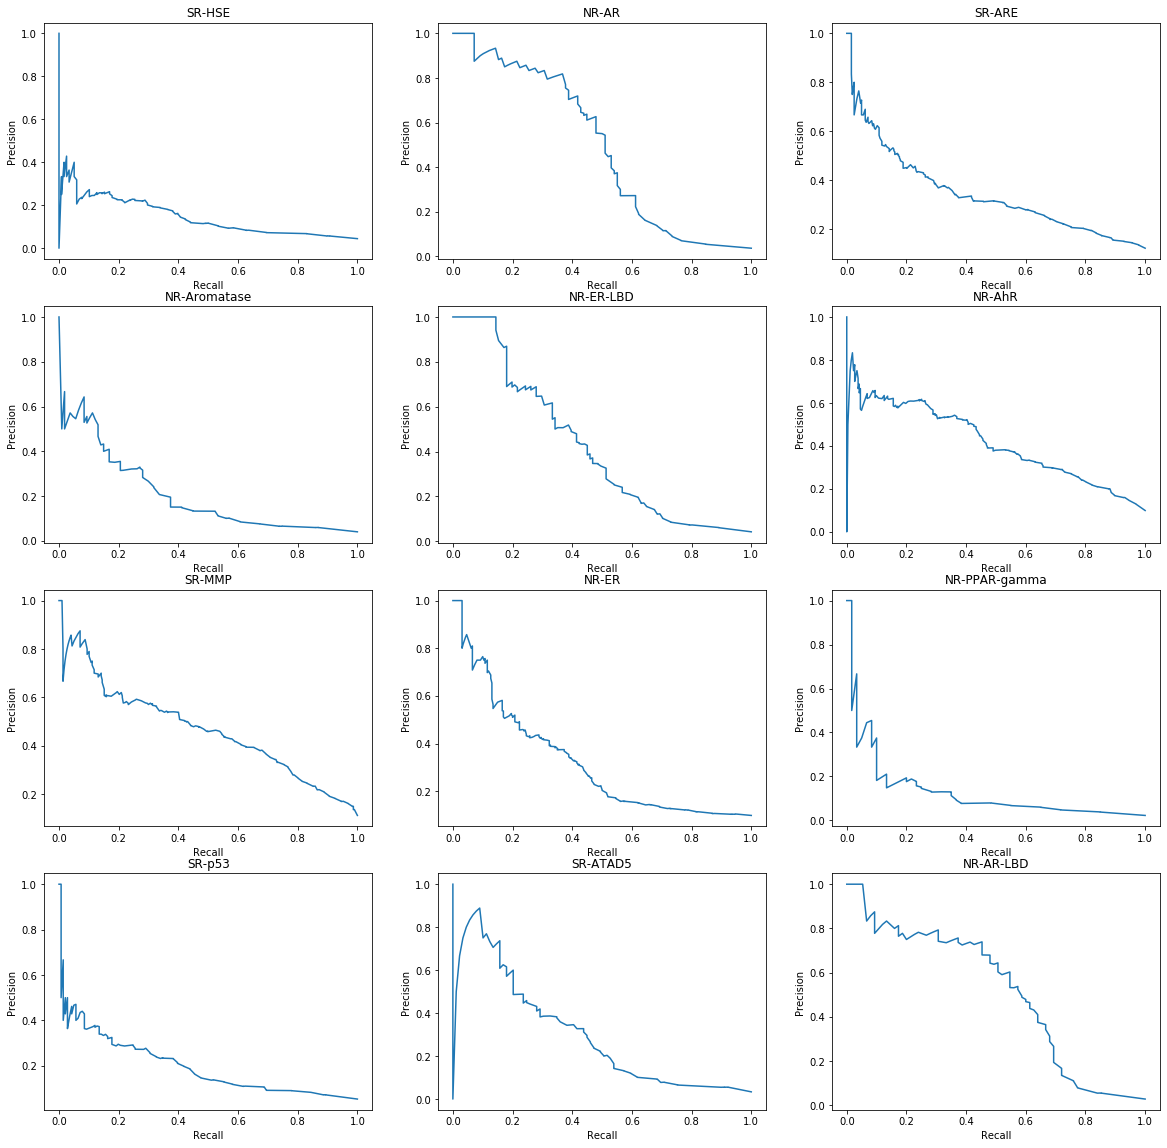

In [186]:
test_panel.plot_recall_precision(y_score, extra_index = False)

### XGBoostClassifier

#### Training

In [187]:
y_pred, y_score = get_pred_and_scores(xgb_model, X_train)
y_obs = y_train.values

test_panel = testing.panel_of_test(targets, X_train, y_train.values, sample_weights = mask_train.values)
test_panel.compute_basic_metrics(y_pred, y_score)

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,1,0.666667,0.8,0.957642,0.980339,0.833333,0.833333
NR-AR,0.982558,0.79717,0.880208,0.986429,0.990815,0.898272,0.898272
SR-ARE,0.987952,0.635659,0.773585,0.958503,0.939955,0.817084,0.817084
NR-Aromatase,0.994048,0.818627,0.897849,0.995081,0.990507,0.909182,0.909182
NR-ER-LBD,0.988889,0.723577,0.835681,0.972939,0.985337,0.861568,0.861568
NR-AhR,0.987715,0.768642,0.864516,0.977377,0.971944,0.883691,0.883691
SR-MMP,0.990177,0.782609,0.874241,0.984192,0.963659,0.890557,0.890557
NR-ER,0.989583,0.528757,0.689238,0.923123,0.93933,0.763973,0.763973
NR-PPAR-gamma,1,0.728682,0.843049,0.980376,0.992103,0.864341,0.864341
SR-p53,1,0.796552,0.886756,0.991512,0.987325,0.898276,0.898276


#### Testing

In [192]:
y_pred, y_score = get_pred_and_scores(xgb_model, X_test)
y_obs = y_test.values

test_panel = testing.panel_of_test(targets, X_test, y_test.values, sample_weights = mask_test.values)
xgb_test_metrics = test_panel.compute_basic_metrics(y_pred, y_score)
xgb_test_metrics

/Users/rezacolindoobary/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:655: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)
/Users/rezacolindoobary/opt/anaconda3/envs/ml_env/lib/python3.6/site-packages/sklearn/metrics/_ranking.py:655: RuntimeWarning: invalid value encountered in true_divide
  precision = tps / (tps + fps)


,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,0.421053,0.0677966,0.116788,0.19373,0.944698,0.531241,0.531241
NR-AR,0.792453,0.428571,0.556291,0.534299,0.972709,0.711952,0.711952
SR-ARE,0.642857,0.167183,0.265356,0.419321,0.847371,0.574423,0.574423
NR-Aromatase,0.642857,0.0841121,0.14876,0.261264,0.947395,0.540705,0.540705
NR-ER-LBD,0.690476,0.261261,0.379085,0.406397,0.959729,0.627739,0.627739
NR-AhR,0.730769,0.288973,0.414169,0.53387,0.903153,0.637333,0.637333
SR-MMP,0.654412,0.299663,0.411085,0.563237,0.869029,0.635589,0.635589
NR-ER,0.64557,0.196154,0.300885,0.368364,0.886819,0.590443,0.590443
NR-PPAR-gamma,0.5,0.0666667,0.117647,0.136329,0.97235,0.532385,0.532385
SR-p53,0.461538,0.0851064,0.143713,0.233607,0.937032,0.539267,0.539267


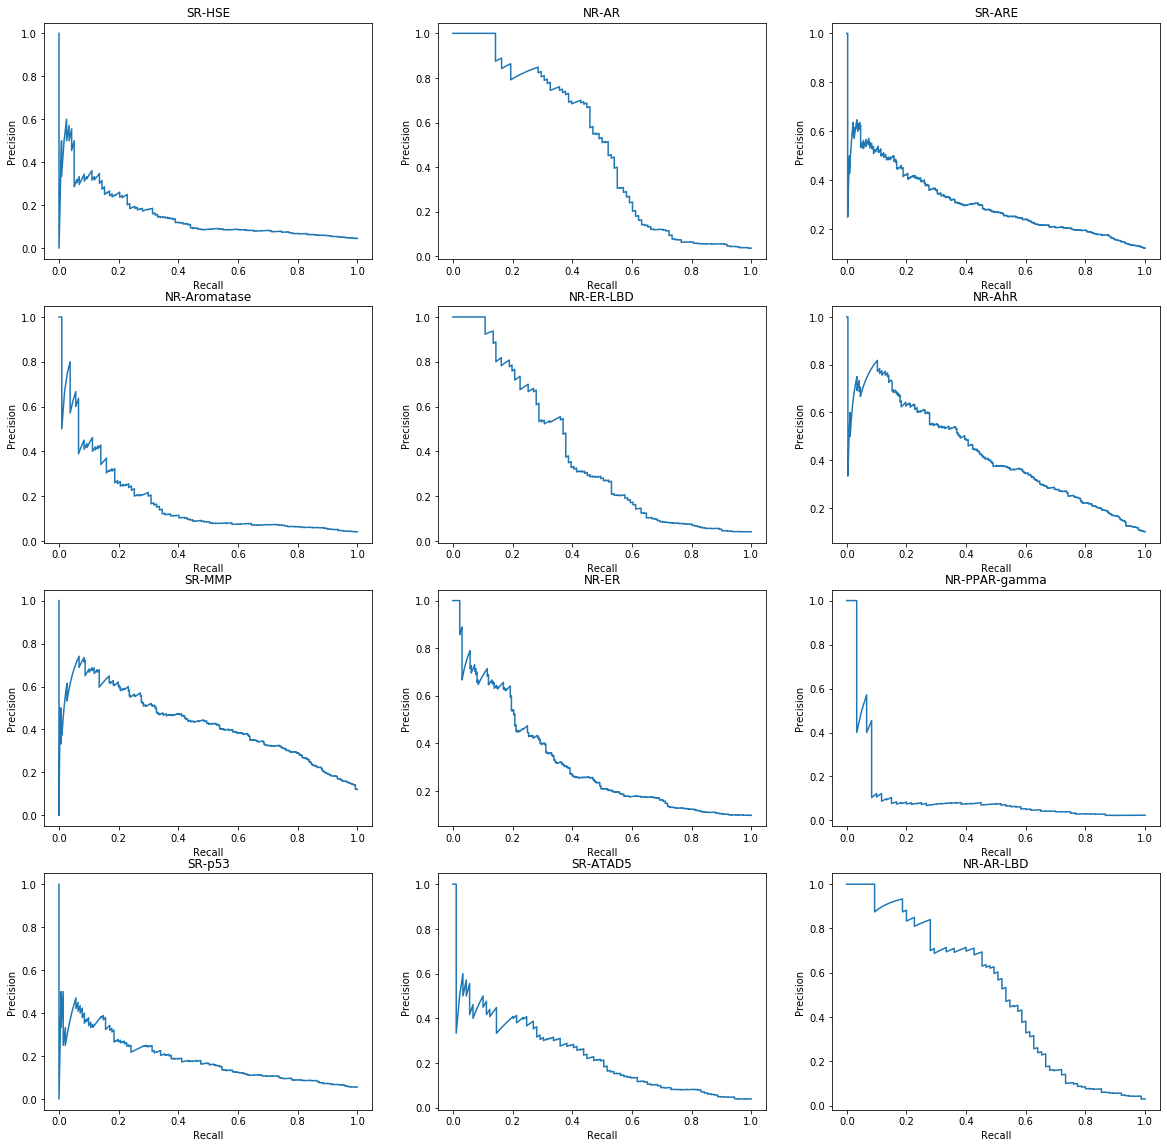

In [190]:
test_panel.plot_recall_precision(y_score, extra_index = False)

## Conclusion

In this notebook, we developed some very simple benchmark models for the dataset.
Whilst dong this in mind, we kept in mind the various processings and testing tasks that need to be done. 

A quick analysis of the results above shows that Random Forest performed the better of the two. We can see this by simple comparing the means:

In [211]:
result = pd.DataFrame(index = ['Precision', 'Recall', 'F1', 'AUPRC', 'Accuracy', 'Balanced Accuracy','ROC_AUC'])

In [217]:
def temp_f(x):
    if x:
        return 'RF'
    else:
        return 'XGB'
(rf_test_metrics > xgb_test_metrics).applymap(lambda x: temp_f(x))

,Precision,Recall,F1,AUPRC,Accuracy,Balanced Accuracy,ROC_AUC
SR-HSE,RF,XGB,XGB,XGB,RF,XGB,XGB
NR-AR,XGB,XGB,XGB,XGB,XGB,XGB,XGB
SR-ARE,RF,XGB,XGB,RF,XGB,XGB,XGB
NR-Aromatase,RF,XGB,RF,RF,RF,RF,RF
NR-ER-LBD,RF,XGB,XGB,RF,XGB,XGB,XGB
NR-AhR,RF,XGB,XGB,XGB,XGB,XGB,XGB
SR-MMP,RF,XGB,XGB,RF,RF,XGB,XGB
NR-ER,XGB,XGB,XGB,XGB,XGB,XGB,XGB
NR-PPAR-gamma,XGB,XGB,XGB,RF,XGB,XGB,XGB
SR-p53,RF,XGB,XGB,RF,RF,XGB,XGB


Interestingly, RF wins on our more relevant metrics, however XGB wins more of the metrics.